# Tutorial 2: Simulating Interpolated Designs

In [1]:
%load_ext autoreload
%autoreload 2

## Get Target Interpolated Design
Find the best geometries for your desired Hamiltonian parameters the same way as in Tutorial 1:

In [2]:
from squadds import SQuADDS_DB

db = SQuADDS_DB()
db.select_system("qubit")
db.select_qubit("TransmonCross")
df = db.create_system_df()
# df

In [3]:
from squadds import Analyzer
analyzer = Analyzer(db)

target_params={"qubit_frequency_GHz": 4, "anharmonicity_MHz": -200}

results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

 d:\Anaconda\envs\clark_qiskit_metal\Lib\site-packages\squadds\core\analysis.py: 242


,design_options,design_tool,renderer_options,setup,simulator,PI,date_created,group,institution,uploader,...,cross_to_claw,cross_to_cross,cross_to_ground,ground_to_ground,units,EC,EJ,EJEC,qubit_frequency_GHz,anharmonicity_MHz
643,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,5.25204,102.49025,102.49025,255.94708,fF,0.179783,12.278081,68.293903,4.013772,-201.551532
1862,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,2.89095,104.64079,104.64079,233.88902,fF,0.180135,12.278081,68.160443,4.017505,-201.973598
1714,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,2.62986,104.89818,104.89818,230.69451,fF,0.180141,12.278081,68.158098,4.017570,-201.981031


In [4]:
best_device = results.iloc[0]
best_device

design_options         {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...
design_tool                                                 qiskit-metal
renderer_options       {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...
setup                  {'auto_increase_solution_order': True, 'enable...
simulator                                                     Ansys HFSS
PI                                                Eli Levenson-Falk, PhD
date_created                                           2023-09-20-142547
group                                                                LFL
institution                                                          USC
uploader                                                       Andre Kuo
claw_to_claw                                                   106.91739
claw_to_ground                                                 101.13161
cross_to_claw                                                    5.25204
cross_to_cross                                     

## Simulate the Target Design

Once you have the target design (in this case in Qiskit Metal format), you can then simulate it in whichever application you choose. However, we provide a native API to make it easier to get started with simulation on Ansys HFSS (support for AWS Palace will be provided hopefully in the near future!).   

We use the `AnsysSimulator` class to run simulations:

In [5]:
from squadds import AnsysSimulator

The `AnsysSimulator` object takes the analyzer from before and the target "best device" that you want to simulate as parameters.

In [7]:
ansys_simulator = AnsysSimulator(analyzer, best_device)

selected system: qubit


In [7]:
best_device

claw_to_claw                                                   106.91739
claw_to_ground                                                 101.13161
cross_to_claw                                                    5.25204
cross_to_cross                                                 102.49025
cross_to_ground                                                102.49025
ground_to_ground                                               255.94708
units                                                                 fF
renderer_options       {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...
setup                  {'auto_increase_solution_order': True, 'enable...
simulator                                                     Ansys HFSS
PI                                                Eli Levenson-Falk, PhD
date_created                                           2023-09-20-142547
group                                                                LFL
institution                                        

In [8]:
best_device_geometry = best_device["design_options"]
best_device_geometry

{'aedt_hfss_capacitance': 0,
 'aedt_hfss_inductance': 9.686e-09,
 'aedt_q3d_capacitance': 0,
 'aedt_q3d_inductance': 1e-08,
 'chip': 'main',
 'connection_pads': {'c': {'claw_cpw_length': '40um',
   'claw_cpw_width': '10um',
   'claw_gap': '5.1um',
   'claw_length': '190um',
   'claw_width': '15um',
   'connector_location': '90',
   'connector_type': '0',
   'ground_spacing': '10um'}},
 'cross_gap': '30um',
 'cross_length': '210um',
 'cross_width': '30um',
 'gds_cell_name': 'my_other_junction',
 'hfss_capacitance': 0,
 'hfss_inductance': 9.686e-09,
 'hfss_mesh_kw_jj': 7e-06,
 'hfss_resistance': 0,
 'layer': '1',
 'orientation': '-90',
 'pos_x': '-1500um',
 'pos_y': '1200um',
 'q3d_capacitance': 0,
 'q3d_inductance': '10nH',
 'q3d_mesh_kw_jj': 7e-06,
 'q3d_resistance': 0}

In [9]:
best_device_sim_setup = best_device["setup"]
best_device_sim_setup

{'auto_increase_solution_order': True,
 'enabled': True,
 'freq_ghz': 5.0,
 'max_passes': 30,
 'min_converged_passes': 1,
 'min_passes': 2,
 'name': 'sweep_setup',
 'percent_error': 0.1,
 'percent_refinement': 30,
 'reuse_selected_design': False,
 'reuse_setup': False,
 'run': {'box_plus_buffer': True,
  'components': array(['Q'], dtype=object),
  'name': 'sweep_v2.0',
  'open_terminations': array([array(['Q', 'c'], dtype=object)], dtype=object)},
 'save_fields': False,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

Then, simulate your device with Ansys HFSS. In this case, we are simulating a TransmonCross object to get its corresponding capacitance matrix using LOM analysis.

In [38]:
ansys_results = ansys_simulator.simulate(best_device)
ansys_results

the parameters ['run'] are unsupported, so they have been ignored
{'pos_x': '-1500um', 'pos_y': '1200um', 'orientation': '-90', 'chip': 'main', 'layer': '1', 'connection_pads': {'c': {'connector_type': '0', 'claw_length': '190um', 'ground_spacing': '10um', 'claw_width': '15um', 'claw_gap': '5.1um', 'claw_cpw_length': '40um', 'claw_cpw_width': '10um', 'connector_location': '90'}}, 'cross_width': '30um', 'cross_length': '210um', 'cross_gap': '30um', 'hfss_inductance': 9.686e-09, 'hfss_capacitance': 0, 'hfss_resistance': 0, 'hfss_mesh_kw_jj': 7e-06, 'q3d_inductance': '10nH', 'q3d_capacitance': 0, 'q3d_resistance': 0, 'q3d_mesh_kw_jj': 7e-06, 'gds_cell_name': 'my_other_junction', 'aedt_q3d_inductance': 1e-08, 'aedt_q3d_capacitance': 0, 'aedt_hfss_inductance': 9.686e-09, 'aedt_hfss_capacitance': 0}


INFO 12:29PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d23 [Solution type: Q3D]
WARNING 12:29PM [connect_setup]: 	No design setup detected.
WARNING 12:29PM [connect_setup]: 	Creating Q3D default setup.
INFO 12:29PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


<COMObject GetModule>


INFO 12:29PM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 12:29PM [analyze]: Analyzing setup sweep_setup
INFO 12:33PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpgb9njht7.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 12:33PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmph3n7zgty.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 12:33PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmph9emuwek.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 12:33PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpza998269.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 12:33PM [get_matrix]: Exporting matrix dat

{'design': {'design_options': {'pos_x': '-1500um',
   'pos_y': '1200um',
   'orientation': '-90',
   'chip': 'main',
   'layer': '1',
   'connection_pads': {'c': {'connector_type': '0',
     'claw_length': '190um',
     'ground_spacing': '10um',
     'claw_width': '15um',
     'claw_gap': '5.1um',
     'claw_cpw_length': '40um',
     'claw_cpw_width': '10um',
     'connector_location': '90'}},
   'cross_width': '30um',
   'cross_length': '210um',
   'cross_gap': '30um',
   'hfss_inductance': 9.686e-09,
   'hfss_capacitance': 0,
   'hfss_resistance': 0,
   'hfss_mesh_kw_jj': 7e-06,
   'q3d_inductance': '10nH',
   'q3d_capacitance': 0,
   'q3d_resistance': 0,
   'q3d_mesh_kw_jj': 7e-06,
   'gds_cell_name': 'my_other_junction',
   'aedt_q3d_inductance': 1e-08,
   'aedt_q3d_capacitance': 0,
   'aedt_hfss_inductance': 9.686e-09,
   'aedt_hfss_capacitance': 0},
  'design_tool': 'Qiskit Metal'},
 'sim_options': {'sim_type': 'lom',
  'setup': {'name': 'sweep_setup',
   'reuse_selected_design':

After your simulation is finished, you have the option to take screenshots of your design in the renderer and in Qiskit Metal to verify your geometry visually, as follows:

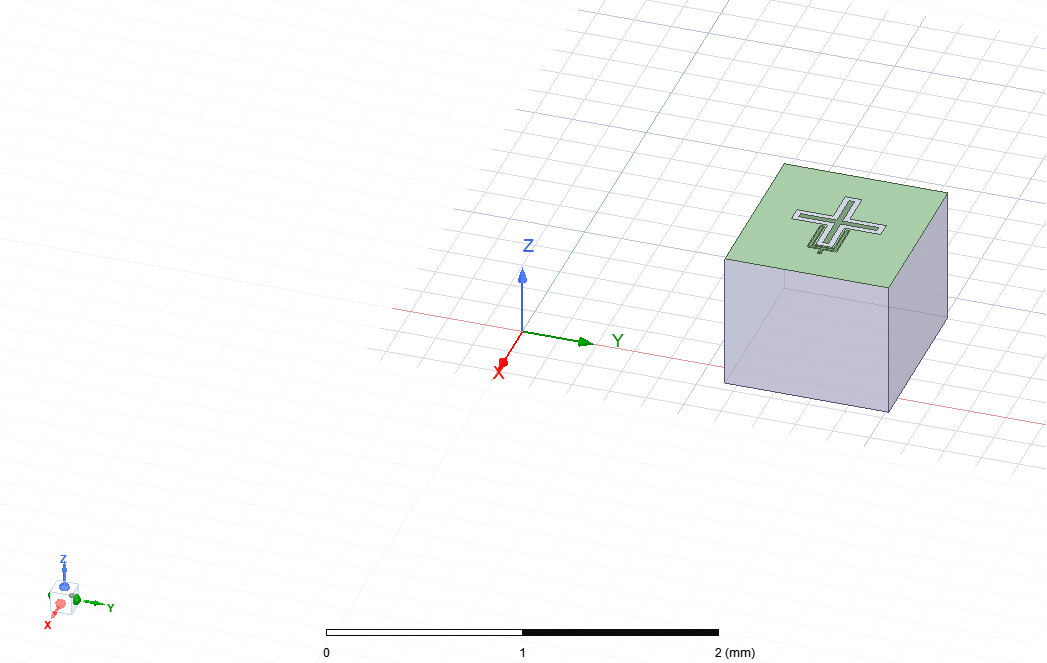

In [40]:
ansys_simulator.get_renderer_screenshot()

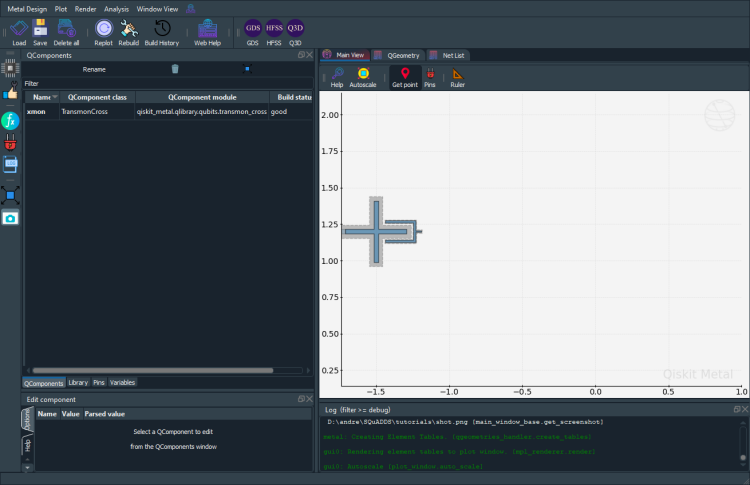

In [39]:
ansys_simulator.get_design_screenshot()

We can also analyze the simulated capacitance matrix results using the `get_xmon_info()` function, which returns to you `qubit_anharmonicity_MHz` and  `qubit_frequency_GHz`.

In [46]:
ansys_simulator.get_xmon_info(ansys_results)

NameError: name 'ansys_results' is not defined

## Simulating an Interpolated Qubit + Cavity device

This time, we look for a complete device, which includes a TransmonCross object coupled to a RouteMeander CPW and CoupledLineTee, as in Tutorial 1.

In [6]:
db.select_system(["qubit","cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_coupler("CLT")
merged_df = db.create_system_df()
merged_df

,design_options_qubit,design_tool_qubit,renderer_options,setup_qubit,simulator_qubit,PI_qubit,date_created_qubit,group_qubit,institution_qubit,uploader_qubit,...,simulator_cavity_claw,PI_cavity_claw,date_created_cavity_claw,group_cavity_claw,institution_cavity_claw,uploader_cavity_claw,cavity_frequency,kappa,units_cavity_claw,design_options
0,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-09-204334,LFL,USC,Andre Kuo,8.963333e+09,282985.474218,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...
1,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-06-224829,LFL,USC,Andre Kuo,6.911806e+09,689394.209468,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...
2,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-04-124953,LFL,USC,Andre Kuo,8.968642e+09,205609.615066,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...
3,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-08-173545,LFL,USC,Andre Kuo,6.767688e+09,36337.102863,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...
4,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,Ansys HFSS,"Eli Levenson-Falk, PhD",2023-11-30-214122,LFL,USC,Andre Kuo,6.576639e+09,136678.807988,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11599,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-09-204334,LFL,USC,Andre Kuo,7.817014e+09,156255.430260,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...
11600,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-06-224829,LFL,USC,Andre Kuo,6.205101e+09,553122.868310,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...
11601,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,Ansys HFSS,"Eli Levenson-Falk, PhD",2023-12-08-173545,LFL,USC,Andre Kuo,6.086092e+09,22779.404355,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...
11602,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,Ansys HFSS,"Eli Levenson-Falk, PhD",2023-11-30-214122,LFL,USC,Andre Kuo,5.930010e+09,105620.528697,Hz,{'cavity_claw_

In [7]:
target_params = {
                "qubit_frequency_GHz": 4,
                "cavity_frequency_GHz": 6.2,
                "kappa_kHz": 120,
                "resonator_type":"quarter",
                "anharmonicity_MHz": -200,
                "g_MHz": 70}

In [8]:
analyzer = Analyzer(db)

results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

 d:\Anaconda\envs\clark_qiskit_metal\Lib\site-packages\squadds\core\analysis.py: 242


,design_options_qubit,design_tool_qubit,renderer_options,setup_qubit,simulator_qubit,PI_qubit,date_created_qubit,group_qubit,institution_qubit,uploader_qubit,...,cavity_frequency_GHz,kappa_kHz,units_cavity_claw,design_options,EC,EJ,EJEC,qubit_frequency_GHz,anharmonicity_MHz,g_MHz
9376,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-09-20-142547,LFL,USC,Andre Kuo,...,6.429384,128.174331,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...,0.163509,12.278081,75.091151,3.836546,-182.146843,68.095121
1868,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-10-25-153123,LFL,USC,Andre Kuo,...,6.516700,133.933868,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...,0.183089,12.278081,67.060880,4.048670,-205.518797,70.226899
6526,"{'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...",qiskit-metal,"{'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...","{'auto_increase_solution_order': True, 'enable...",Ansys HFSS,"Eli Levenson-Falk, PhD",2023-10-25-153123,LFL,USC,Andre Kuo,...,6.486978,135.979146,Hz,{'cavity_claw_options': {'coupling_type': 'CLT...,0.173690,12.278081,70.689451,3.948506,-194.262295,70.978895


In [9]:
best_device = results.iloc[0]
best_device

design_options_qubit          {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...
design_tool_qubit                                                  qiskit-metal
renderer_options              {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...
setup_qubit                   {'auto_increase_solution_order': True, 'enable...
simulator_qubit                                                      Ansys HFSS
PI_qubit                                                 Eli Levenson-Falk, PhD
date_created_qubit                                            2023-09-20-142547
group_qubit                                                                 LFL
institution_qubit                                                           USC
uploader_qubit                                                        Andre Kuo
claw_to_claw                                                          113.99245
claw_to_ground                                                        107.65111
cross_to_claw                           

After getting our best result, we once again initialize our AnsysSimulator object, this time on our new system, and then simulate.

In [10]:
ansys_simulator = AnsysSimulator(analyzer, best_device)

selected system: ['qubit', 'cavity_claw']


Starting the Simulation


INFO 03:10PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:10PM [load_ansys_project]: 	Opened Ansys App
INFO 03:10PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 03:10PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project45
INFO 03:10PM [connect_design]: No active design found (or error getting active design).
INFO 03:10PM [connect]: 	 Connected to project "Project45". No design detected
INFO 03:11PM [connect_design]: 	Opened active design
	Design:    CavitySweep [Solution type: Eigenmode]
WARNING 03:11PM [connect_setup]: 	No design setup detected.
WARNING 03:11PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:11PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


INFO 03:11PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
WARNING 03:11PM [connect_setup]: 	No design setup detected.
WARNING 03:11PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:11PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


Sim rendered into HFSS!
{'mesh1': {'objects': ['prime_cpw_cplr', 'second_cpw_cplr', 'trace_cpw', 'readout_connector_arm_claw'], 'MaxLength': '7um'}}
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\ANSYS\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\ANSYS\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


INFO:Global:Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


pyaedt INFO: Project Project45 set to active.


INFO:Global:Project Project45 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 03:11PM [get_setup]: 	Opened setup `test_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:11PM [analyze]: Analyzing setup test_setup
03:13PM 25s INFO [get_f_convergence]: Saved convergences to d:\Andre\SQuADDS\tutorials\hfss_eig_f_convergence.csv


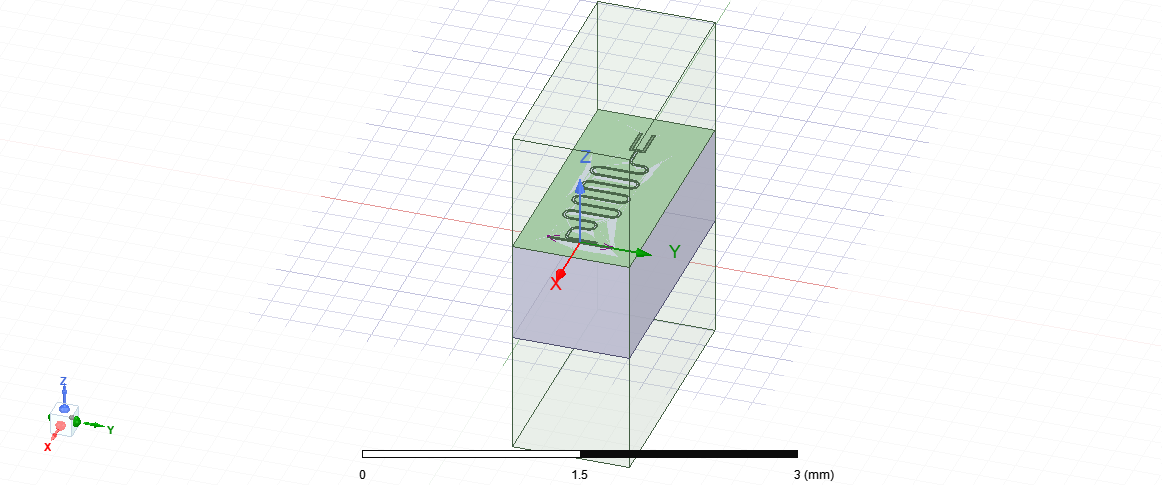

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 6.304 GHz
Q = 58908.3
kappa = 0.107 MHz
the parameters ['run'] are unsupported, so they have been ignored
{'pos_x': '-1500um', 'pos_y': '1200um', 'orientation': '-90', 'chip': 'main', 'layer': '1', 'connection_pads': {'c': {'connector_type': '0', 'claw_length': '210um', 'ground_spacing': '10um', 'claw_width': '15um', 'claw_gap': '5.1um', 'claw_cpw_length': '40um', 'claw_cpw_width': '10um', 'connector_location': '90'}}, 'cross_width': '30um', 'cross_length': '230um', 'cross_gap': '30um', 'hfss_inductance': 9.686e-09, 'hfss_capacitance': 0, 'hfss_resistance': 0, 'hfss_mesh_kw_jj': 7e-06, 'q3d_inductance': '10nH', 'q3d_capacitance': 0, 'q3d_resistance': 0, 'q3d_mesh_kw_jj': 7e-06, 'gds_cell_name': 'my_other_junction', 'aedt_q3d_inductance': 1e-08, 'aedt_q3d_capacitance': 0, 'aedt_hfss_inductance': 9.686e-09, 'aedt_hfss_capacitance': 0}


INFO 03:13PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:13PM [load_ansys_project]: 	Opened Ansys App
INFO 03:13PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 03:13PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project45
INFO 03:13PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 03:13PM [get_setup]: 	Opened setup `test_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:13PM [connect]: 	Connected to project "Project45" and design "CavitySweep_hfss" 😀 

INFO 03:13PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d [Solution type: Q3D]
WARNING 03:13PM [connect_setup]: 	No design setup detected.
WARNING 03:13PM [connect_setup]: 	Creating Q3D default setup.
INFO 03:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:13PM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 0

{'sim_options': {'setup': {'eigenmode_setup': {'basis_order': 1,
    'max_delta_f': 0.05,
    'max_passes': 50,
    'min_converged': 1,
    'min_converged_passes': 2,
    'min_freq_ghz': 1,
    'min_passes': 1,
    'n_modes': 1,
    'name': 'Setup',
    'pct_refinement': 30,
    'reuse_selected_design': True,
    'reuse_setup': True,
    'vars': {'Cj': '0fF', 'Lj': '0nH'}},
   'LOM_setup': {'auto_increase_solution_order': True,
    'enabled': True,
    'freq_ghz': 5.0,
    'max_passes': 30,
    'min_converged_passes': 1,
    'min_passes': 2,
    'name': 'sweep_setup',
    'percent_error': 0.1,
    'percent_refinement': 30,
    'reuse_selected_design': False,
    'reuse_setup': False,
    'run': {'box_plus_buffer': True,
     'components': array(['Q'], dtype=object),
     'name': 'sweep_v2.0',
     'open_terminations': array([array(['Q', 'c'], dtype=object)], dtype=object)},
    'save_fields': False,
    'solution_order': 'High',
    'solver_type': 'Iterative'}},
  'simulator': 'Ansys H

In [11]:
ansys_results = ansys_simulator.simulate(best_device)
ansys_results

To extract the simulated Hamiltonian parameters, we look at the `sim_results` key in our `ansys_results` dictionary:

In [27]:
hamiltonian_results = ansys_results["sim_results"]
hamiltonian_results

{'f_cavity': 6303810826.410001,
 'Q': 58908.254628354814,
 'kappa': 107010.65353540001,
 'g': 71.71037491448273,
 'a': -179.0868260223526,
 'f_qubit': 4.451631293329893}

We can similarly get screenshots from Qiskit Metal and the Ansys renderer. Notice that the TransmonCross object and the cavity+claw object are rendered into the same design in Qiskit Metal. This is done purely out of convenience, and has no effect on the simulation results. This is shown in the renderer screenshots below, which show the TransmonCross and cavity+claw being rendered and simulated separately.

03:16PM 25s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



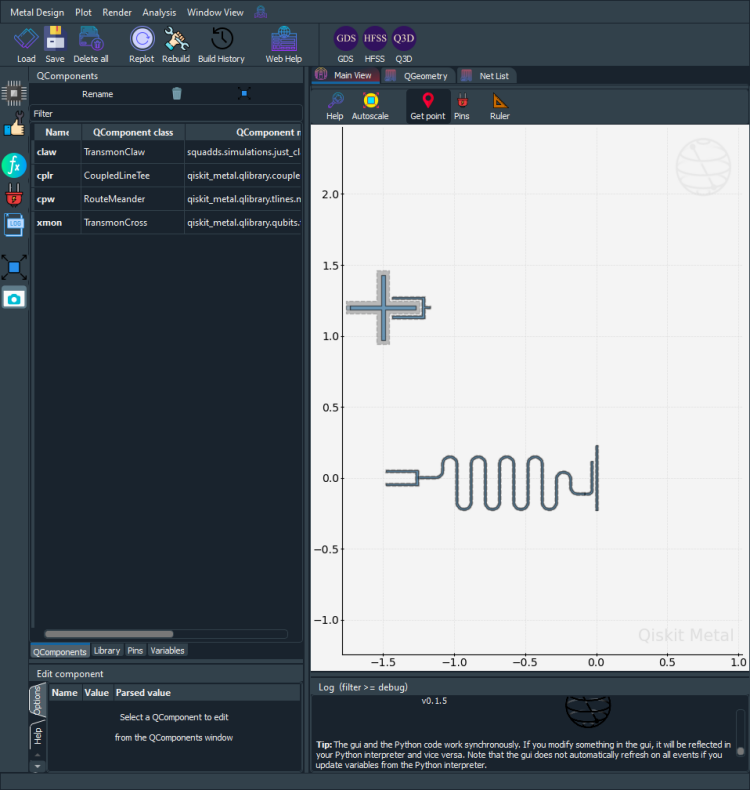

In [12]:
ansys_simulator.get_design_screenshot()

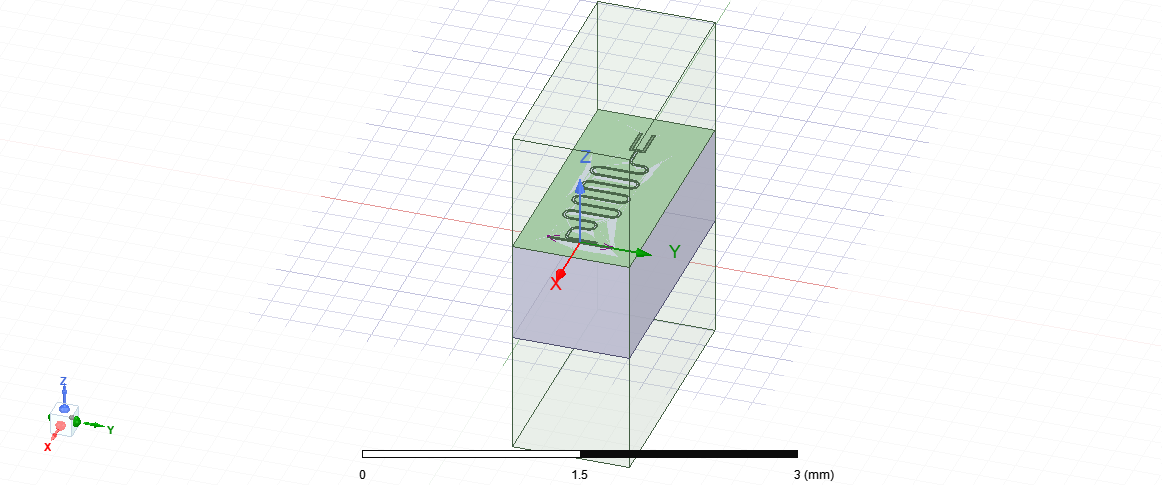

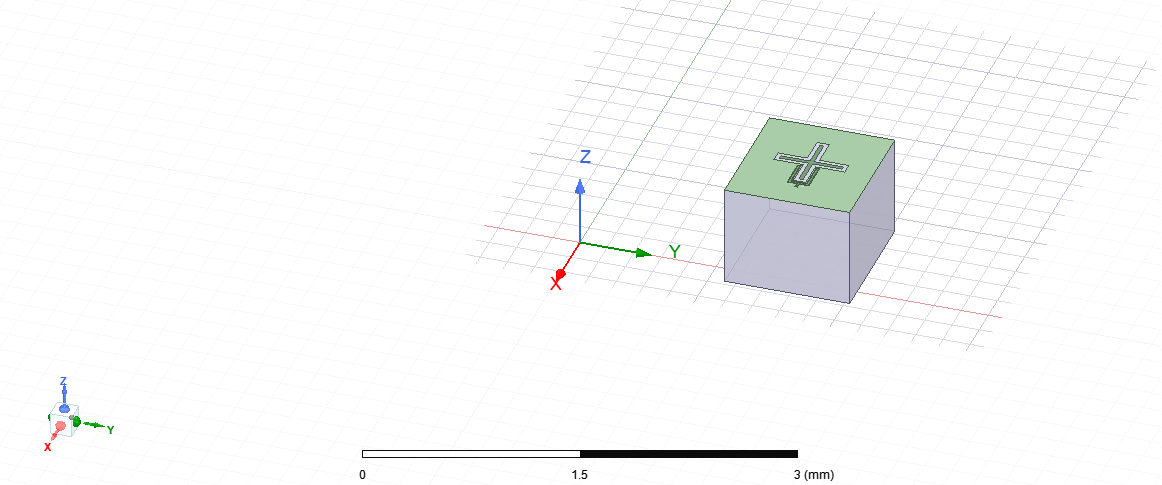

In [13]:
ansys_simulator.get_renderer_screenshot()

We can also plot our complete custom QubitCavity device in Qiskit Metal. 

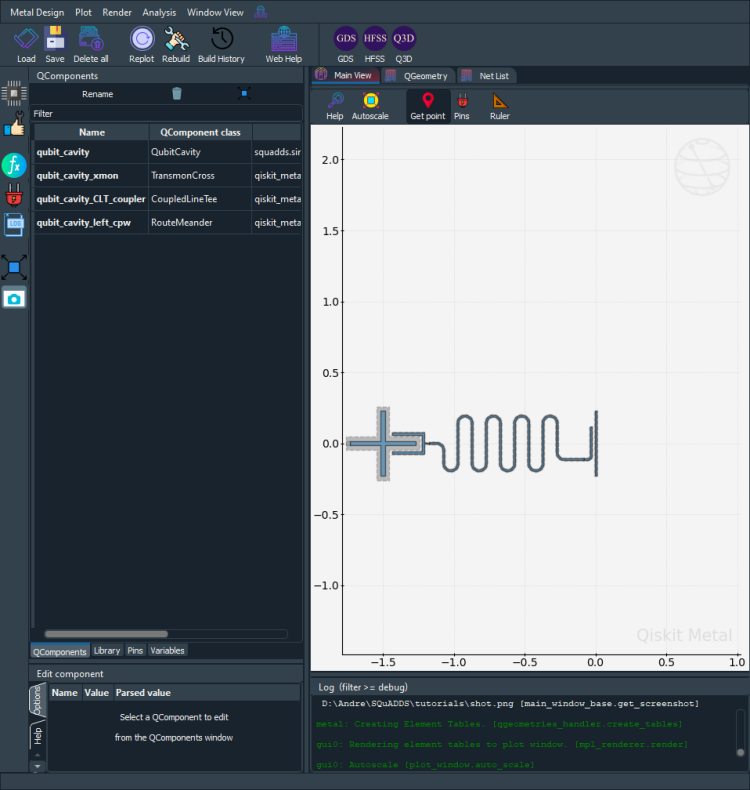

In [26]:
ansys_simulator.plot_device(ansys_results)

## License
<div style='width: 100%; background-color:#d5d9e0;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2023.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>
